In [ ]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

In [1]:
import pandas as pd
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datasets import Dataset, ClassLabel, Value, load_dataset
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, classification_report



Use GPU if available, otherwise use cpu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_name = 'distilbert-base-uncased'

#### Remove Unwanted columns, rename the target variable as "labels" as Transformers library expects the target variable to be named labels

In [5]:
data = pd.read_csv('final dataset/full_emotion_dataset.csv')
data = data[['String','Emotion_code']]
data = Dataset.from_pandas(data)
data = data.rename_column('Emotion_code','labels')
#convert the datatype of labels to ClassLabel from String
new_features = data.features.copy()
new_features['labels'] = ClassLabel(num_classes=7, names=['neutral', 'joy','sadness','anger', 'love','surprise','fear'], names_file=None, id=None)
data = data.cast(new_features)
data.features

Casting the dataset:   0%|          | 0/5365 [00:00<?, ? examples/s]

{'String': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['neutral', 'joy', 'sadness', 'anger', 'love', 'surprise', 'fear'], id=None)}

## Import the Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(batch):
  return tokenizer(
    batch['String'], padding=True, truncation=True, max_length= 510, return_tensors='pt'
  )


# Iteration - 1

### Split the dataset into train and validation

In [7]:
dataset = data.train_test_split(test_size=0.2)

Create a dictionary to map id2label and label2id

In [8]:
id2label = {idx:dataset['train'].features['labels'].int2str(idx) for idx in range(0,7)}
label2id = {value:key for key, value in id2label.items()}

### Tokenize the strings

In [9]:
tokenized_data = dataset.map(tokenize_function, batched=True, batch_size=None)
tokenized_data.column_names

Map:   0%|          | 0/4292 [00:00<?, ? examples/s]

Map:   0%|          | 0/1073 [00:00<?, ? examples/s]

{'train': ['String', 'labels', 'input_ids', 'attention_mask'],
 'test': ['String', 'labels', 'input_ids', 'attention_mask']}

Remove unwanted columns

In [10]:
tokenized_data = tokenized_data.remove_columns(['String'])

In [11]:
tokenized_data.column_names

{'train': ['labels', 'input_ids', 'attention_mask'],
 'test': ['labels', 'input_ids', 'attention_mask']}

In [14]:
batch_size = 64
logging_steps = len(dataset['train']) // batch_size
training_args = TrainingArguments(
    output_dir='iteration-1/model',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
    metric_for_best_model="f1",
    do_train=True,
    do_eval=True,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='iteration_1/logs',
)


In [18]:
num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, id2label=id2label,label2id=label2id
            ).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.796900,1.610775,0.421742
2,1.472600,1.412039,0.478838
3,1.272400,1.369095,0.491128
4,1.129700,1.367473,0.499780
5,1.031400,1.391868,0.494372
6,0.945200,1.404693,0.500432
7,0.881700,1.415872,0.499372
8,0.822500,1.419357,0.498323


TrainOutput(global_step=544, training_loss=1.1655744962832506, metrics={'train_runtime': 77.3756, 'train_samples_per_second': 443.758, 'train_steps_per_second': 7.031, 'total_flos': 559716384394944.0, 'train_loss': 1.1655744962832506, 'epoch': 8.0})

In [32]:
history = trainer.state.log_history

In [74]:
training_loss = []
val_loss = []
f1_iter1 = []
epoch = [1,2,3,4,5,6,7,8]
for i in range(0,16,2):
  training_loss.append(history[i]['loss'])

for i in range(1,16,2):
  val_loss.append(history[i]['eval_loss'])

for i in range(1,16,2):
  f1_iter1.append(history[i]['eval_f1'])

Text(0.5, 1.0, 'Training and validation loss graph')

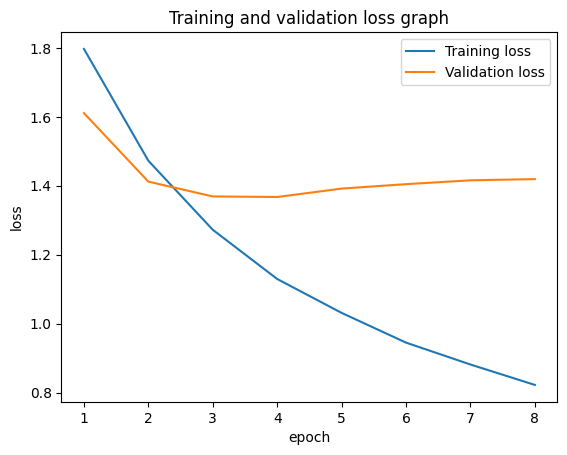

In [48]:
plt.figure()
sns.lineplot(y=training_loss,x=epoch, label = 'Training loss')
sns.lineplot(y=val_loss, x=epoch, label = 'Validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and validation loss graph")

# Iteration 2
### We are changing the training arguments by increasing the batch size to 1024 and decreasing the learning rate. We are increasing the train data size.

In [21]:
logging_steps = len(dataset['train']) // 1024
training_arguments2 = TrainingArguments(
    output_dir='iteration-2',
    per_device_train_batch_size=254,
    per_device_eval_batch_size=254,
    num_train_epochs=8,
    learning_rate=6e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
    metric_for_best_model="f1",
    do_train=True,
    do_eval=True,
    weight_decay=0.7,
    load_best_model_at_end=True,
    logging_dir='iteration-2/logs2',
)

In [22]:
dataset2 = data.train_test_split(test_size=0.1)

In [23]:
data_encoded2 = dataset2.map(tokenize_function, batched=True, batch_size=None)

Map:   0%|          | 0/4828 [00:00<?, ? examples/s]

Map:   0%|          | 0/537 [00:00<?, ? examples/s]

In [24]:
data_encoded2.set_format("torch", columns=['input_ids','attention_mask','labels'])

In [25]:
data_encoded2['train'].features

{'String': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['neutral', 'joy', 'sadness', 'anger', 'love', 'surprise', 'fear'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [26]:
trainer2 = Trainer(
    model=model,
    args=training_arguments2,
    compute_metrics=compute_metrics,
    train_dataset=data_encoded2['train'],
    eval_dataset=data_encoded2['test']
)

In [27]:
trainer2.train()

Epoch,Training Loss,Validation Loss,F1
1,0.898700,0.951916,0.678015
2,0.629900,0.924192,0.697856
3,0.533800,0.959808,0.693044
4,0.468300,0.967362,0.695058
5,0.390600,1.008888,0.703945
6,0.204100,1.034530,0.695790
7,0.182200,1.066057,0.688259
8,0.159600,1.062154,0.698956


TrainOutput(global_step=160, training_loss=0.5202996592968703, metrics={'train_runtime': 83.4092, 'train_samples_per_second': 463.066, 'train_steps_per_second': 1.918, 'total_flos': 809505935785152.0, 'train_loss': 0.5202996592968703, 'epoch': 8.0})

The model has returned Good results than before. In the next iteration only the DAIR dataset will be used.

In [53]:
history2 = trainer2.state.log_history

In [63]:
training_loss2 = []
val_loss2 = []
f1_iter2 = []
train_epoch = []
val_epoch = []
for i in range(0,48):
  try:
    training_loss2.append(history2[i]['loss'])
    train_epoch.append(history2[i]['epoch'])
  except:
    val_loss2.append(history2[i]['eval_loss'])
    val_epoch.append(history2[i]['epoch'])
    f1_iter2.append(history2[i]['eval_f1'])



Text(0, 0.5, 'loss')

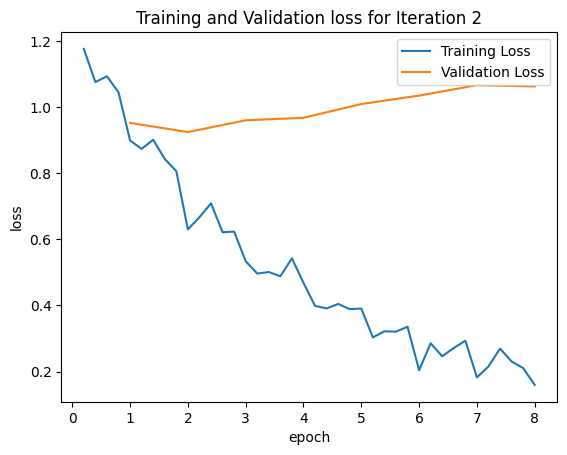

In [181]:
plt.figure()
sns.lineplot(x=train_epoch,y=training_loss2, label='Training Loss')
sns.lineplot(y=val_loss2, x=val_epoch, label="Validation Loss")
plt.title('Training and Validation loss for Iteration 2')
plt.xlabel('epoch')
plt.ylabel('loss')

In [73]:
f1_iter2

[0.6780153071126794,
 0.6978557795600657,
 0.6930440621226736,
 0.6950582135348274,
 0.7039453767062785,
 0.6957900883151269,
 0.6882590473658242,
 0.698955849549476]

Text(0, 0.5, 'f1 score')

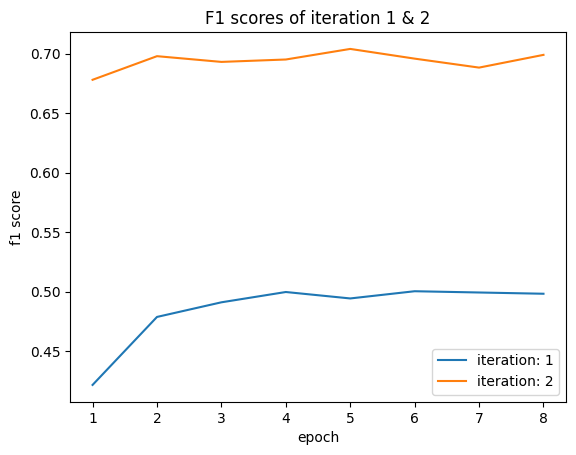

In [76]:
plt.figure()
sns.lineplot(x=epoch,y=f1_iter1, label='iteration: 1')
sns.lineplot(x=epoch,y=f1_iter2, label='iteration: 2')
plt.title("F1 scores of iteration 1 & 2")
plt.xlabel('epoch')
plt.ylabel('f1 score')

In [29]:
model.save_pretrained('iteration-2/trained_model')
tokenizer.save_pretrained('iteration-2/trained_model')

('iteration-2/trained_model/tokenizer_config.json',
 'iteration-2/trained_model/special_tokens_map.json',
 'iteration-2/trained_model/vocab.txt',
 'iteration-2/trained_model/added_tokens.json',
 'iteration-2/trained_model/tokenizer.json')

# Iteration - 3

In This iteration the model will be trained with emotion data by DAIR AI

In [96]:
emo_data = load_dataset("emotion")

In [98]:
emo_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [100]:
emo_data['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [102]:
id2label = {idx:emo_data['train'].features['label'].int2str(idx) for idx in range(0,6)}
label2id = {value:key for key, value in id2label.items()}

In [103]:
emo_data.rename_column('label','labels')

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [107]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_function(batch):
  return tokenizer(
    batch['text'], padding=True, truncation=True, max_length= 510, return_tensors='pt'
  )

In [108]:
tokenized_data = emo_data.map(tokenize_function, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [116]:
tokenized_data = tokenized_data.remove_columns(['text'])

In [118]:
tokenized_data['train'].features

{'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [168]:
tokenized_data.rename_column('label','labels')

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [169]:
tokenized_data.set_format('torch')

In [170]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The same training arguments used for iteration 2 will be used in this iteration as well since it yielded good results

In [171]:
logging_steps = len(dataset['train']) // 1024
args3 = TrainingArguments(
    output_dir='iteration-3/model',
    per_device_train_batch_size=254,
    per_device_eval_batch_size=254,
    num_train_epochs=8,
    learning_rate=4e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
    metric_for_best_model="f1",
    do_train=True,
    do_eval=True,
    weight_decay=0.7,
    load_best_model_at_end=True,
    logging_dir='iteration-3/logs',
)

In [173]:
trainer3 = Trainer(
    model=model,
    args=args3,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test']
)

In [174]:
trainer3.train()

Epoch,Training Loss,Validation Loss,F1
1,0.378200,0.295230,0.904253
2,0.183600,0.187623,0.919793
3,0.127400,0.158131,0.928222
4,0.110200,0.155923,0.924362
5,0.067300,0.162164,0.923309
6,0.049100,0.178640,0.925499
7,0.044800,0.180705,0.923676
8,0.040100,0.181243,0.921979


TrainOutput(global_step=504, training_loss=0.20029529883334088, metrics={'train_runtime': 271.4295, 'train_samples_per_second': 471.577, 'train_steps_per_second': 1.857, 'total_flos': 2881371446784000.0, 'train_loss': 0.20029529883334088, 'epoch': 8.0})

In [175]:
history3 = trainer3.state.log_history

In [177]:
len(history3)

135

In [178]:
training_loss3 = []
val_loss3 = []
f1_iter3 = []
train_epoch3 = []
val_epoch3 = []
for i in range(0,134):
  try:
    training_loss3.append(history3[i]['loss'])
    train_epoch3.append(history3[i]['epoch'])
  except:
    val_loss3.append(history3[i]['eval_loss'])
    val_epoch3.append(history3[i]['epoch'])
    f1_iter3.append(history3[i]['eval_f1'])

Text(0, 0.5, 'loss')

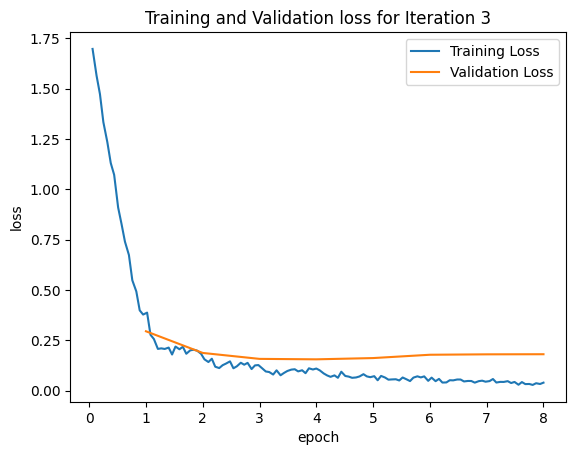

In [182]:
plt.figure()
sns.lineplot(x=train_epoch3,y=training_loss3, label='Training Loss')
sns.lineplot(y=val_loss3, x=val_epoch3, label="Validation Loss")
plt.title('Training and Validation loss for Iteration 3')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'F1 score')

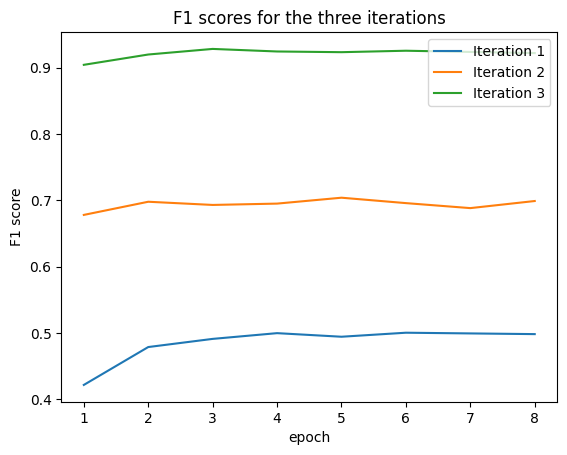

In [180]:
plt.figure()
sns.lineplot(x=epoch,y=f1_iter1, label='Iteration 1')
sns.lineplot(y=f1_iter2, x=epoch, label="Iteration 2")
sns.lineplot(y=f1_iter3, x=epoch, label="Iteration 3")
plt.title('F1 scores for the three iterations')
plt.xlabel('epoch')
plt.ylabel('F1 score')

In [157]:
model.save_pretrained('classifier')
tokenizer.save_pretrained('classifier')

('iteration-3/trained_model/tokenizer_config.json',
 'iteration-3/trained_model/special_tokens_map.json',
 'iteration-3/trained_model/vocab.txt',
 'iteration-3/trained_model/added_tokens.json',
 'iteration-3/trained_model/tokenizer.json')

## Test Results

In [213]:
trainer.evaluate(tokenized_data['test'])

{'eval_loss': 0.16667820513248444,
 'eval_f1': 0.93090385691753,
 'eval_runtime': 1.1703,
 'eval_samples_per_second': 1709.027,
 'eval_steps_per_second': 27.344}

In [232]:
preds = trainer3.predict(tokenized_data['test'])

In [216]:
y_true

tensor([0, 0, 0,  ..., 1, 1, 4])

In [217]:
y_preds

array([0, 0, 0, ..., 1, 1, 4])

In [233]:
y_true = tokenized_data['test']['label']
y_preds = preds.predictions.argmax(-1)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [234]:
f1_scores = f1_score(y_true, y_preds,average=None)

In [235]:
df = pd.DataFrame({'emotion':labels,'f1_score':f1_scores})


In [237]:
df

,emotion,f1_score
0,sadness,0.968295
1,joy,0.944526
2,love,0.828571
3,anger,0.926554
4,fear,0.907173
5,surprise,0.722222


Text(0.5, 1.0, 'F1 scores for each emotion')

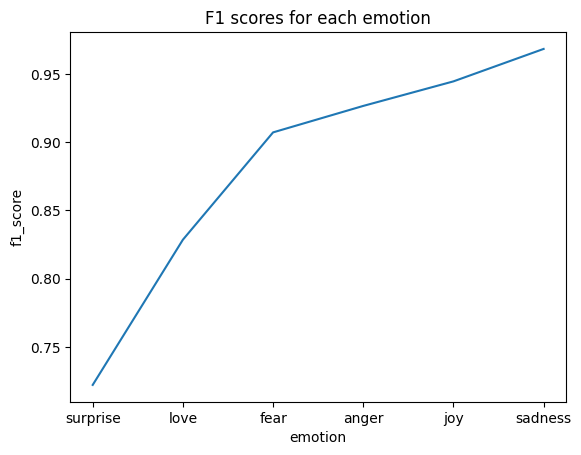

In [244]:
plt.figure()
sns.lineplot(data=df.sort_values(by='f1_score'), x='emotion', y='f1_score')
plt.title("F1 scores for each emotion")